# Reinforcement Learning Prediction
In this notebook, we want to use RL to predict the optimal portfolio weight on the market index. We first get a well trained RL agent on the training data set. The well trained RL agent is the optimal policy that can maximizing the expected discounted utility over the trainning period. We test the trained agent on the last state and get the action (weight). This action is the prediction of the optimal weight on the market index for the next one period. We rolling the training data set one period ahead and repeat the same procedure to obtain the optimal weight on market index for the second OOS period.

In [2]:
import gym
import numpy as np
import pandas as pd
from gym import spaces
import random
import sys
sys.path.append('../module')
from typing import Tuple
import matplotlib.pyplot as plt

from RL_env import EconMarketEnv
from stable_baselines3 import PPO
from stable_baselines3.common.callbacks import EvalCallback

from data_handler import get_econ_predictors, \
                         get_quarterly_date_format, \
                        get_monthly_date_format, \
                        get_equities_returns_volatility,\
                        get_equities_returns,\
                        get_env_data

from RL_model import get_policy_in_sample_performance, \
                    evaluate_agent_action
%matplotlib inline

For training an RL agent, we consider a infinite horizon problem. The state, action and reward is defined in [MODEL_RL_env_fin](MODEL_RL_env_fin.ipynb). The RL agent optimize the expected total reward over an infinite time period. The objective function is defined as:
$$
\begin{equation}
\max_{\pi} \mathbb{E} \left[ \sum_{t=0}^{\infty} \gamma^{t-1} r_t \right]
\end{equation}
$$
where $\pi$ is the policy, $\gamma$ is the discount factor, and $r_t$ is the reward at time $t$. To make a prediction of optimal portfolio weight at time $m+1$, we firstly get an well-trained RL agent on the data from $t = 1$ to $t = m$. Then we use the last state of the training data set. The last state is the state at time $m$. We use the trained RL agent to get the action (weight) at time $m$. This action is the prediction of the optimal weight on the market index for the next one period. We rolling the training data set one period ahead and repeat the same procedure to obtain the optimal weight on market index for the second OOS period. In practice, we don't have infinite time horizon. We can only train the RL agent on the data from $t = 1$ to $t = m$. We treat a large $m$, especially when $m > 10$, as the infinite time horizon.

In practice, the training data expanding when we rolling the prediction period one period ahead. For each prediction period $m$, we create an training environment with the training data from $t = 1$ to $t = m - 1$. We also create a testing environment including data at period $m$ to calculate the reward. But we only apply the RL agent on the testing data set once. We don't update the RL agent on the testing data set. We only use the RL agent to get the action (weight) at time $m - 1$ and apply it on time $m$. This action is the prediction of the optimal weight on the market index for time $m$. 

In [2]:
# start date is one quarter before the actual training date to accomodate for the lagged predictors
START_DATE = '1946-12'
END_DATE = '2021-12'
data, equities_returns, equities_returns_vol = get_env_data(START_DATE, END_DATE)

In [3]:
from sklearn.model_selection import TimeSeriesSplit
DATA_FREQUENCY = 4
WINDOW_SIZE = 18
SAMPLE_SIZE = data.shape[0] # to be change to time series index
tscv = TimeSeriesSplit(n_splits = SAMPLE_SIZE - DATA_FREQUENCY * WINDOW_SIZE , test_size=1)

In [4]:
def get_rl_weight_prediction(train_tick, test_tick, data):
    """
    Returns the predicted portfolio weights from a reinforcement learning model.

    Parameters
    ----------
    train_tick : array-like
        The indices of the training data, which must be a subset of the data indices.
    test_tick : array-like
        The indices of the test data, which must be a subset of the data indices.
    data : pandas.DataFrame
        The data used to train and test the model, with the time index in the first column.

    Returns
    -------
    pandas.Series
        The predicted portfolio weights for the last period of the test data.

    Notes
    -----
    This function trains a reinforcement learning model on a subset of the data, then evaluates the model on another
    subset of the data, and finally returns the predicted portfolio weights for the last period of the test data.
    """

    train_index = data.index[train_tick]
    test_index = data.index[train_tick.tolist() + test_tick.tolist()]
    start_date = train_index[0].strftime('%Y-%m')
    end_date_train = train_index[-1].strftime('%Y-%m')
    end_date_test = test_index[-1].strftime('%Y-%m')

    # training env
    data, equities_returns, equities_returns_vol = get_env_data(start_date, end_date_train)
    features_dict = {'volatility': equities_returns_vol}
    env_data_dict = {'state': data, 
                    'portfolio': equities_returns, 
                    'features': features_dict}
    env_train = EconMarketEnv(env_data_dict, gamma = 3)

    # evaluate env
    env_eval = EconMarketEnv(env_data_dict, gamma = 3)

    # testing env
    data, equities_returns, equities_returns_vol = get_env_data(start_date, end_date_test)
    features_dict = {'volatility': equities_returns_vol}
    env_data_dict = {'state': data, 
                    'portfolio': equities_returns, 
                    'features': features_dict}
    env_test = EconMarketEnv(env_data_dict, gamma = 3)

    # training
    eval_callback = EvalCallback(env_eval, 
                             best_model_save_path=f"../../log/model/{end_date_train}/",
                             eval_freq=1000,
                             deterministic=True, 
                             render=False,
                             verbose=0)
    model = PPO("MlpPolicy", env_train, tensorboard_log="../../log/tensorboard_rolling_train/", verbose=0)
    model.learn(int(2e5), progress_bar=False, callback=eval_callback)

    # test and get predicted weight
    model = PPO.load(f'../../log/model/{end_date_train}/best_model', env=env_test)
    performance = get_policy_in_sample_performance(env_test, model)
    performance.iloc[-1].to_csv(f'../../log/performance/{end_date_test}.csv')
    
    return performance.iloc[-1]

In [5]:
from joblib import Parallel, delayed

In [6]:
pred_rl = Parallel(n_jobs=-1)(delayed(get_rl_weight_prediction)(train_tick, test_tick, data) for i, (train_tick, test_tick) in enumerate(tscv.split(data)))

In [ ]:
pd.DataFrame(pred_rl).to_csv(f'../../log/pred_rl_{START_DATE}_{END_DATE}.csv')

In [3]:
pred_rl = pd.read_csv('../../log/pred_rl_1946-12_2021-12.csv', index_col=0, parse_dates=True)
pred_rl.index = pd.PeriodIndex(pred_rl.index, freq='Q')

In [5]:
pred_rl.mean()

action              0.503555
portfolio return    0.018352
dtype: float64

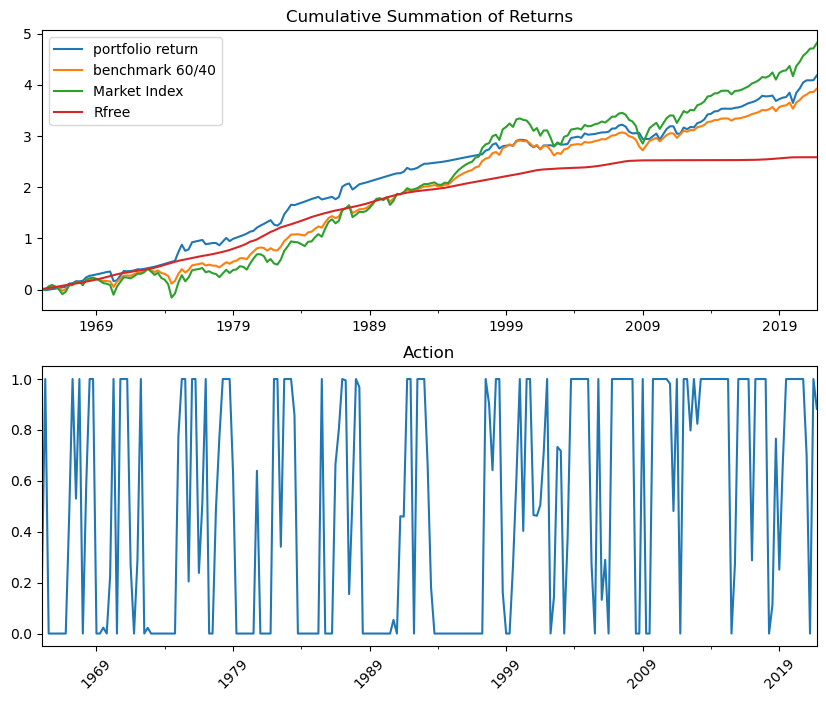

In [3]:
sharpe_ratio, fig, performance_df = evaluate_agent_action(pred_rl)

In [4]:
sharpe_ratio

portfolio return    0.348529
benchmark 60/40     0.357121
dtype: float64

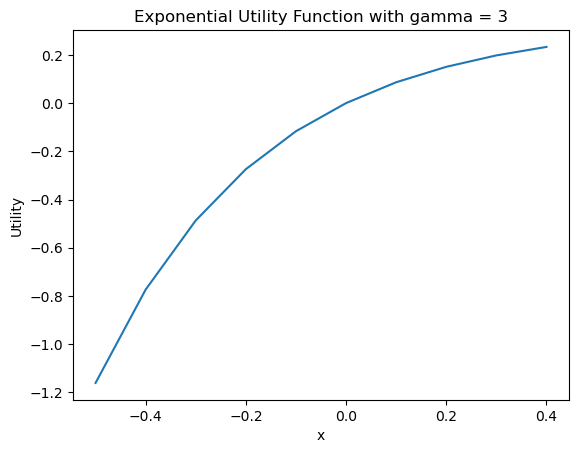

In [9]:
import matplotlib.pyplot as plt
import numpy as np

def exponential_utility(x: float, gamma: float) -> float:
    return (1 - np.exp(-gamma * x)) / gamma if gamma != 0 else x

x_vals = np.arange(-.5, 0.5, 0.1)

gamma = 3

y_vals = exponential_utility(x_vals, gamma)

plt.plot(x_vals, y_vals)

plt.xlabel("x")
plt.ylabel("Utility")
plt.title(f"Exponential Utility Function with gamma = {gamma}")

plt.show()
